# Task 3 - Build a Linear Forecasting Model
In this task, we're going to employ linear regressions in a manner very similar to the latter portion of **D4**. Specifically, going to build a model to predict future income with some variables that you choose (points for the best model!). I'll also ask you to evaluate how your model performs for various types of companies.

### Data files
1. Compustat (Annual Financial Statement Data) from 2009 to 2019. Note that the full computstat manual is available through WRDS, but I've summarized some of the variables provided below:
    * AT: Total Assets
    * LT: Total Liabilities
    * CEQ: Common Equity
    * ACT: Current Assets
    * LCT: Current Liabilities
    * XRD: R&D Expense
    * XSGA: SG&A (Total)
    * XAD: Advertising Expense
    * SALE: Total revenue
    * DP: Depreciation & Amortization
    * OIBDP: Operating Income before Depreciation
    * IB: Income Before Extraordinary Items
    * OANCF: Operating Cash Flows
    * PRCC_F: Price at end of fiscal year
    * CSHO: Common Shares Outstanding
 
2. CRSP (Monthly Stock Return Data) from 2008 to 2019. As with Compustat, the full compustat manual is available through WRDS, but I've summarized some of the variables provided below:
    * RET: Returns inclusive of reinvested dividends
    * VWRETD: Value weighted market return including reinvested dividends
    * BID: End of month closing "best bid"
    * ASK: End of month closing "best ask" (or offer)
    * PRC: Share Price at end of month

### Requirements (summarized here, given in more detail below)
1. Set up data and generate a table of summary statistics
2. Estimate a very simple in-sample forecasting model, then expand to consider at least 3 alternatives.
3. Build process to forecast out-of-sample, by year; evaluate performance of each of the models you develop in #2 using MSE.
4. Evaluate whether earnings model works better or worse for large vs. small firms, and growth vs. value stocks.
5. (6046 only) Evaluate which industry has lowest and highest out-of-sample MSE. You can use two-digit SIC codes to define industry. Comment on whether you find your results intuitive.

## Requirement 1
Let's start by setting up variables in Compustat and CRSP. I'm going to help get you started, but what you decide to do in part 2 will require you to revisit this step and define the variables you wish to use.

First load each dataset:

In [ ]:
import pandas as pd, numpy as np

folder = "/Users/cooperdenning/PycharmProjects/pythonProject5/.venv/Task 3/Task3Data" # update to correct folder path

# Load datasets
comp = pd.read_sas(f"{folder}/Task3-Compustat.sas7bdat",encoding='utf8')
crsp = pd.read_sas(f"{folder}/Task3-CRSP.sas7bdat",encoding='utf8')

# drop the "SPREAD" variable in CRSP to avoid confusion
crsp = crsp.drop(columns=["SPREAD"])
print(comp)
print(crsp)

Next, we're going to delete firms in financial services industries (SIC codes between 6000 and 6999). These companies report a little differently, so we should probably exclude from this exercise since a forecasting model for them would require different inputs.

Remove these firms now (hint: create a *mask* that identifies the inverse of rows with SIC codes in the range provided above):

In [20]:
# Convert SIC column to numeric, coercing errors to NaN for non-numeric entries
comp['SIC'] = pd.to_numeric(comp['SIC'], errors='coerce')

# Create a mask for rows where SIC code is *not* in the range 6000 to 6999 and filter out NaN
mask = ~comp['SIC'].between(6000, 6999, inclusive='both')

# Filter out financial services firms and rows with NaN SIC codes
comp = comp[mask & comp['SIC'].notna()]


Next, go ahead and create two variables, `lag_at` and `lag_mve` as the lagged versions of total assets and total market value of equity.

In [21]:
comp['mve'] = comp.eval('PRCC_F*CSHO')
comp = comp.sort_values(by=['GVKEY','DATADATE'])
comp['lag_mve'] = comp.groupby(['GVKEY'])['mve'].shift(1)
comp['lag_at'] = comp.groupby(['GVKEY'])['AT'].shift(1)
comp.head(10)

,GVKEY,DATADATE,FYEAR,TIC,SIC,CONM,CUSIP,ACT,AT,CEQ,...,PRCC_F,CONSOL,INDFMT,DATAFMT,POPSRC,CURCD,COSTAT,mve,lag_mve,lag_at
0,001004,2010-05-31,2009.0,AIR,5080,AAR CORP,000361105,863.429,1501.042,746.906,...,19.70,C,INDL,STD,D,USD,A,777.83480,NaN,NaN
1,001004,2011-05-31,2010.0,AIR,5080,AAR CORP,000361105,913.985,1703.727,835.845,...,26.39,C,INDL,STD,D,USD,A,1049.82059,777.83480,1501.042
2,001004,2012-05-31,2011.0,AIR,5080,AAR CORP,000361105,1063.272,2195.653,864.649,...,12.05,C,INDL,STD,D,USD,A,485.28965,1049.82059,1703.727
3,001004,2013-05-31,2012.0,AIR,5080,AAR CORP,000361105,1033.700,2136.900,918.600,...,20.06,C,INDL,STD,D,USD,A,790.00292,485.28965,2195.653
4,001004,2014-05-31,2013.0,AIR,5080,AAR CORP,000361105,1116.900,2199.500,999.500,...,24.30,C,INDL,STD,D,USD,A,961.30800,790.00292,2136.900
5,001004,2015-05-31,2014.0,AIR,5080,AAR CORP,000361105,954.100,1515.000,845.100,...,29.54,C,INDL,STD,D,USD,A,1046.39542,961.30800,2199.500
6,001004,2016-05-31,2015.0,AIR,5080,AAR CORP,000361105,873.100,1442.100,865.800,...,24.41,C,INDL,STD,D,USD,A,842.51115,1046.39542,1515.000
7,001004,2017-05-31,2016.0,AIR,5080,AAR CORP,000361105,888.500,1504.100,914.200,...,34.94,C,INDL,STD,D,USD,A,1200.32876,842.51115,1442.100
8,001004,2018-05-31,2017.0,AIR,5080,AAR CORP,000361105,942.700,1524.700,936.300,...,44.69,C,INDL,STD,D,USD,A,1551.45804,1200.32876,1504.100
9,001004,2019-05-31,2018.0,AIR,5080,AAR CORP,000361105,952.500,1517.200,905.900,...,30.09,C,INDL,STD,D,USD,A,1046.77092,1551.45804,1524.700


Next, let's compute two variables from the `crsp` dataset: (1) rolling 12 month buy-and-hold returns, and (2) average bid-ask spreads. Refer to your final two variables as `mar12` (for market-adjusted return) and `bidask12`. I've started the code for you below:

In [22]:
# Compute bid-ask spread as (ASK - BID)/PRC
crsp['spread'] = (crsp['ASK'] - crsp['BID']) / crsp['PRC']

# Compute rolling values (hint - remember to use logged returns)
crsp['log_ret'] = np.log(1+crsp['RET'])
crsp['log_mkt'] = np.log(1+crsp['VWRETD'])

## Insert code to create rolling returns ##
crsp['rolling_log_mkt'] = (
    crsp.groupby('PERMNO')['log_mkt'] # initial groupby
    .rolling(window=12, min_periods=12)  # 12-month window, require 12 observations to compute
    .sum() # compute the sum of each rolling window
    .reset_index(level=0, drop=True)  # remove the multi-index caused by groupby and rolling, allowing merge back to original
)
crsp['rolling_log_ret'] = (
    crsp.groupby('PERMNO')['log_ret'] # initial groupby
    .rolling(window=12, min_periods=12)  # 12-month window, require 12 observations to compute
    .sum() # compute the sum of each rolling window
    .reset_index(level=0, drop=True)  # remove the multi-index caused by groupby and rolling, allowing merge back to original
)

# Convert to buy-and-hold returns and average bid-ask spread
crsp['mar12'] = np.exp(crsp['rolling_log_ret']) - np.exp(crsp['rolling_log_mkt'])
crsp['bidask12'] = (
    crsp.groupby('PERMNO')['spread'] # initial groupby
    .rolling(window=12, min_periods=12)  # 12-month window, require 12 observations to compute
    .mean() # compute the sum of each rolling window
    .reset_index(level=0, drop=True)  # remove the multi-index caused by groupby and rolling, allowing merge back to original
)

Now, merge with compustat. Remember to correct the CUSIP code in Compustat before completing the merge. For simplicity, you can ignore the 3-month offset we did in class (i.e., just merge on the same year-month):

In [23]:

# Correct the CUSIP code in compustat by truncating to the first 8 characters
comp['CUSIP'] = comp['CUSIP'].str[:8]

# Create the year-month (ym) object in compustat based on DATADATE
comp['ym'] = comp['DATADATE'].dt.year * 100 + comp['DATADATE'].dt.month

# Create the year-month (ym) object in crsp based on DATE
crsp['ym'] = crsp['DATE'].dt.year * 100 + crsp['DATE'].dt.month

# Perform an inner merge on CUSIP and ym
both = pd.merge(comp, crsp, how='inner', on=['CUSIP', 'ym'])

Now, revenue `info()` for the `both` dataset (which should include both compustat and CRSP data). Comment on which variables are missing in more than 10% of observations in each dataset (if any).

In [24]:
both.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34310 entries, 0 to 34309
Data columns (total 46 columns):
 #   Column           Non-Null Count  Dtype        
---  ------           --------------  -----        
 0   GVKEY            34310 non-null  object       
 1   DATADATE         34310 non-null  datetime64[s]
 2   FYEAR            34310 non-null  float64      
 3   TIC              34310 non-null  object       
 4   SIC              34310 non-null  int64        
 5   CONM             34310 non-null  object       
 6   CUSIP            34310 non-null  object       
 7   ACT              33439 non-null  float64      
 8   AT               34107 non-null  float64      
 9   CEQ              34049 non-null  float64      
 10  LCT              33453 non-null  float64      
 11  LT               34034 non-null  float64      
 12  DP               34057 non-null  float64      
 13  IB               34083 non-null  float64      
 14  OIBDP            34058 non-null  float64      
 15  SA

**Comment on variables that having missing values for a large portion**:


Now, we're going to construct some variables to use. I'm going to provide a few, but you are welcome to construct additional ones (HINT: If you use XRD, XAD, or XSGA, I recommend using `fillna(0)` to deal with missing values):

In [25]:
# Here are several different options, but I encourage you to add some more on your own to consider. 
# These were not deliverately selected but are included to illustrate how you might use some pandas methods

both['earn_at'] = both.eval('IB/lag_at')
both['fut_earn_at'] = both.groupby(['GVKEY'])['IB'].shift(-1) / both['lag_at']
both['ocf_at'] = both.eval('OANCF/lag_at')
both['accr_at'] = both.eval('earn_at - ocf_at')
both['sales_growth'] = both.groupby(['GVKEY'])['SALE'].pct_change() # Percent change in sales (can use on others)
both.loc[~np.isfinite(both['sales_growth']),'sales_growth'] = np.nan # addresses zero denominator issues
both['adv_sales'] = both['XAD'].fillna(0) / both['SALE'] # sales growth
both['loss'] = (both['IB']<0).astype(int)
both['loss_earn'] = both['earn_at'] * both['loss']

# Add additional ones. Potential candidates include ratios like book-to-market, current ratio, leverage, other
# interactions, such as those between ratios and key earnings components, or non-linearities, such as other 
# functional forms, squared terms, etc.)
both['Current_Ratio'] = both['ACT']/both['LCT']
both['XRD2'] = both['XRD'].fillna(0) * both['XRD'].fillna(0)
both['XRD/SALE'] = both['XRD'].fillna(0)/both['SALE']

/var/folders/0t/hbx96cfd2rs2d7vnc5s370bc0000gn/T/ipykernel_66986/3103233354.py:8: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  both['sales_growth'] = both.groupby(['GVKEY'])['SALE'].pct_change() # Percent change in sales (can use on others)


Finally, retain only the rows in the dataset that have all the variables you plan to use and those for firms with share prices greater than a dollar and lagged assets more than 10, and review descriptive statistics. Note that I've included an 'original_set' which you should not change, but you SHOULD consider two alternative specifications which you define in "myset1" and "myset2":

In [26]:
# Define your variables here (but don't change "original_set")
xvars = {'original_set':['earn_at','ocf_at','loss','loss_earn','mar12'],
         'myset1':['OIBDP', 'IB', 'SALE', 'AT', 'LT'], # Update with your candidate X variables
         'myset2':['XRD/SALE', 'ACT', 'DP', 'XRD2', 'Current_Ratio'] # update your candidate X variables
        }

required_vars = ['fut_earn_at'] + [x for l in xvars.values() for x in l] # create one list of unique variables
both = both.dropna(subset=required_vars)
both = both.replace([np.inf, -np.inf], np.nan).dropna(subset=required_vars)

# Drop prices less than 1 and lagged assets less than 10
both = both[(both['PRC'] >= 1) & (both['lag_at'] >= 10)]

# Review descriptive statistics for "required_vars"

both[required_vars].describe()

,fut_earn_at,earn_at,ocf_at,loss,loss_earn,mar12,OIBDP,IB,SALE,AT,LT,XRD/SALE,ACT,DP,XRD2,Current_Ratio
count,21368.000000,21368.000000,21368.000000,21368.000000,21368.000000,21368.000000,21368.000000,21368.000000,21368.000000,21368.000000,21368.000000,21368.000000,21368.000000,21368.000000,2.136800e+04,21368.000000
mean,-0.013126,-0.004340,0.064109,0.301619,-0.062037,0.014395,1027.736402,385.503164,5758.882353,8117.246860,4912.337113,3.532607,2357.907946,363.672553,7.282133e+05,2.795761
std,0.340348,0.238635,0.200845,0.458972,0.205171,0.541534,3780.127538,1985.549446,21763.925844,27492.540928,16730.308702,110.668983,8324.901957,1491.880460,1.029512e+07,3.227273
min,-25.537477,-7.220720,-5.879982,0.000000,-7.220720,-1.206356,-21913.000000,-22348.000000,-1964.999000,3.786000,0.087000,-0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,-0.026755,-0.018748,0.038281,0.000000,-0.018748,-0.265383,11.137000,-5.577000,179.128750,248.829000,87.128750,0.000000,110.528500,7.715250,0.000000e+00,1.279483
50%,0.035709,0.037055,0.087253,0.000000,0.000000,-0.043491,110.719500,25.546500,792.298000,1018.291000,490.986000,0.003098,360.380500,38.773000,1.210000e+00,1.946440
75%,0.085131,0.081605,0.139597,1.000000,0.000000,0.183891,517.581250,174.434750,3127.300000,4252.809250,2524.533250,0.079926,1317.109000,158.697250,1.351372e+03,3.137291
max,3.052255,2.604123,2.394618,1.000000,0.000000,15.279515,81730.000000,59531.000000,496785.000000,531864.000000,337980.000000,12991.000000,170929.000000,28430.000000,8.315726e+08,83.000000


Comment on variables where you observe potential outliers:
...

## Requirement 2
Next, you're going to build a few classifiers that run on a pooled model and inspect the R2 value of each. We'll use sklearn since we're not really concerned with individual coefficents. Note that I purposely didn't address outliers yet. We're going to consider two approaches, and see which tends to work better. Specifically, we'll try:

1. Ranking each independent variable and scaling such that it varies between 0 and 1, or
2. Truncating the outer 1% of the sample (instead of winsorizing)

We will set up two functions that accept a dataframe, and return the transformed version of that dataframe. These will be relatively simple so I'll go ahead and provide:

In [27]:
# No need to change anything here

def rankdf(df):
    return (df.rank(axis=0)-1)/(len(df)-1) # creates a fractional rank variable that varies between 0 and 1

def truncatedf(df,outer=0.01): # returns trimmed dataset, removing "outer" percent of observations
    dfr = rankdf(df)
    mask = (dfr.min(axis=1)<outer) | (dfr.max(axis=1)>(1-outer))
    return df[~mask]

Test each function, verifying the descriptive statistics are as you believe they should be (i.e., the ranked df varies between 0 and 1, except for indicators which may be different, and the truncated df has fewer rows with less obvious outliers):

In [28]:
# Generate descriptives for ranked variables
ranked_df = rankdf(both)
ranked_df.describe()

,GVKEY,DATADATE,FYEAR,TIC,SIC,CONM,CUSIP,ACT,AT,CEQ,...,fut_earn_at,ocf_at,accr_at,sales_growth,adv_sales,loss,loss_earn,Current_Ratio,XRD2,XRD/SALE
count,21368.000000,21368.000000,21368.000000,21368.000000,21368.000000,21368.000000,21368.000000,21368.000000,21368.000000,21332.000000,...,21368.000000,21368.000000,21368.000000,21262.000000,21368.000000,21368.000000,21368.000000,21368.000000,21368.000000,21368.000000
mean,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.499158,...,0.500000,0.500000,0.500000,0.497520,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
std,0.288695,0.287812,0.286527,0.288695,0.288634,0.288695,0.288695,0.288695,0.288695,0.288209,...,0.288695,0.288695,0.288695,0.287263,0.257821,0.229497,0.234426,0.288695,0.272979,0.272979
min,0.000164,0.000023,0.008284,0.000164,0.001404,0.000164,0.000047,0.000070,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.349183,0.000000,0.000070,0.236556,0.236556
25%,0.250094,0.206908,0.204381,0.249941,0.250339,0.249988,0.250082,0.250000,0.250000,0.249579,...,0.250000,0.250000,0.250000,0.248760,0.293630,0.349183,0.250000,0.250000,0.236556,0.236556
50%,0.499860,0.457364,0.455726,0.499977,0.498081,0.499860,0.500047,0.500000,0.500000,0.499158,...,0.500000,0.500000,0.500000,0.497520,0.293630,0.349183,0.650817,0.500000,0.500257,0.500000
75%,0.749918,0.707984,0.706393,0.750012,0.749310,0.749871,0.750152,0.750000,0.750000,0.748719,...,0.750000,0.750000,0.750000,0.746279,0.750000,0.849207,0.650817,0.750000,0.750006,0.750000
max,1.000000,0.954767,0.946319,1.000000,0.999204,0.999860,0.999953,1.000000,1.000000,0.998315,...,1.000000,1.000000,1.000000,0.995039,1.000000,0.849207,0.650817,1.000000,1.000000,1.000000


In [29]:
# Generate descriptives for truncated variables
truncateddf = truncatedf(both)
truncateddf.describe()

,DATADATE,FYEAR,SIC,ACT,AT,CEQ,LCT,LT,DP,IB,...,fut_earn_at,ocf_at,accr_at,sales_growth,adv_sales,loss,loss_earn,Current_Ratio,XRD2,XRD/SALE
count,14477,14477.000000,14477.000000,14477.000000,14477.000000,14455.000000,14477.000000,14477.000000,14477.000000,14477.000000,...,14477.000000,14477.000000,14477.000000,14452.000000,14477.000000,14477.000000,14477.000000,14477.000000,1.447700e+04,14477.000000
mean,2015-05-06 08:55:56,2014.374732,4472.952131,1385.645497,4841.505039,1786.158433,939.955466,2952.572838,192.515443,218.341779,...,0.019427,0.088131,-0.063019,0.104950,0.010391,0.247565,-0.028972,2.489437,5.876581e+04,0.106453
min,2011-07-31 00:00:00,2011.000000,1040.000000,7.709000,15.692000,-570.900000,2.294000,3.156000,0.131000,-1040.000000,...,-1.017237,-0.673521,-0.457604,-0.615902,0.000000,0.000000,-0.885893,0.362599,0.000000e+00,0.000000
25%,2013-02-28 00:00:00,2012.000000,3140.000000,141.167000,332.406000,146.498000,60.493000,121.957000,12.017000,0.228000,...,-0.007291,0.052239,-0.093917,-0.015407,0.000000,0.000000,0.000000,1.309698,0.000000e+00,0.000000
50%,2014-12-31 00:00:00,2014.000000,3829.000000,413.157000,1191.119000,488.261000,205.054000,589.312000,45.729000,36.508000,...,0.040244,0.092814,-0.054518,0.061816,0.000000,0.000000,0.000000,1.948091,1.239040e-01,0.000657
75%,2016-12-31 00:00:00,2016.000000,5651.000000,1276.144000,4133.600000,1506.219500,715.000000,2367.539000,154.452000,181.935000,...,0.085355,0.140304,-0.024619,0.159790,0.007213,0.000000,0.000000,2.973474,1.128288e+03,0.061048
max,2018-12-31 00:00:00,2018.000000,8731.000000,38128.000000,122621.000000,57358.000000,29815.900000,82803.000000,7306.584000,7340.000000,...,0.386917,0.408842,0.210721,6.707342,0.178853,1.000000,0.000000,15.476460,1.473792e+07,19.271231
std,NaN,2.245503,1924.011546,2879.060244,10600.164727,3957.096669,2265.975690,6926.261223,468.365938,599.152597,...,0.140348,0.107983,0.072132,0.310832,0.024628,0.431613,0.086348,1.879977,4.971344e+05,0.638074


Before we move to estimation, we're going to remove instances where future earnings exceed the value of lagged assets in absolute value. This may seem arbitrary, but it's unlikely we can do a good job forecasting when a company is literally earning the entire value of assets (or losing it) in a single period:

In [37]:
both = both[both['fut_earn_at'].abs() <= 1]


Now, evaluate each of the three regressor sets your chose, as well as each of the two approaches to data cleaning. Recall that we are evaluating in-sample, we'll simply collect the R2 value (the "score" from each regression).

In [38]:
from sklearn.linear_model import LinearRegression

records = []

for label,x in xvars.items(): # will return label, list of xvars to iterate over
    ols = LinearRegression() 
    
    ranked = rankdf(both[x])  # Ensuring only x variables are included
    truncated = truncatedf(both[x])

    # Fit and score for ranked dataset
    ols.fit(ranked, both.loc[ranked.index, 'fut_earn_at'])
    records.append({
        'xset': label,
        'df': 'ranked',
        'r2': ols.score(ranked, both.loc[ranked.index, 'fut_earn_at'])
    })

    # Fit and score for truncated dataset
    ols.fit(truncated, both.loc[truncated.index, 'fut_earn_at'])
    records.append({
        'xset': label,
        'df': 'truncated',
        'r2': ols.score(truncated, both.loc[truncated.index, 'fut_earn_at'])
    })

resDF = pd.DataFrame(records)


Review the diagnostics in `resDF`. Which model appeared to work best? Which data cleaning approach? Bonus points for a barchart or other visualization that demonstrates the differences!

In [39]:
resDF

,xset,df,r2
0,original_set,ranked,0.506469
1,original_set,truncated,0.545643
2,myset1,ranked,0.295542
3,myset1,truncated,0.039208
4,myset2,ranked,0.208003
5,myset2,truncated,0.167709


*Answer*
The best model seems to be the original set. It has a higher R2 score than both the models I created. In terms of the best method for cleaning the data, for my sets it was the ranked approach but for the professor's sets it seems that it was the truncated approach. Not sure why this could be but if I had to guess it might be that he selected variables that had data that needed to have outliers truncated more than mine. 

## Requirement 3
You're now going to take the work you did in requirement 2 and run it on an out-of-sample basis. The hard(est) work is done at this point. You'll simply set up a loop that iterates over each year of data, trying the different variable sets. Before we get started, examine the sample distribution across years in the sample:

In [40]:
# Generate a list of observations by year (hint-use value_counts() )
both['year'] = both['DATADATE'].dt.year

observations_by_year = both['year'].value_counts().sort_index()
observations_by_year

year
2010       2
2011    2664
2012    2665
2013    2663
2014    2641
2015    2672
2016    2652
2017    2605
2018    2549
Name: count, dtype: int64

From this result, set up your `for` loop. Remember to end the loop one year prior to the end of the sample so you can evaluate out-of-sample fit. We'll collect both mean squared error (as in class) as well as "explained variance score", which essentially an R-squared value. Finally, we're also going to collect the predictions themselves so we can answer the final questions/requirements.

Note that you only need to evaluate the cleaning method that worked **best** in the pooled model (i.e., truncation or ranking).

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, mean_squared_error

# Initialize lists to collect records and predictions
records = []  # collect evaluation metrics
predfs = []   # collect dataframes of predictions for each year

# Define the year range, stopping one year before the last year to allow out-of-sample testing
for yr in range(2011, 2018):  # Insert actual minimum and maximum years here
    preds = []  # will be used to collect predicted earnings from each model for the year

    for label, x in xvars.items():
        # Set up the datasets used for estimation for the current year
        est_data = both.loc[both['FYEAR'] <= yr, x]  # Filter data up to current year for estimation
        est_data = rankdf(est_data) 

        y = both.loc[est_data.index, 'fut_earn_at']  # Set target variable based on `est_data` indices

        # Set up OLS regression and fit it
        ols = LinearRegression()
        ols.fit(est_data, y)  # Fit the model on the current year’s data

        # Predict earnings for the next year (yr + 1)
        next_year_data = both.loc[both['FYEAR'] == yr + 1, x]  # Data for next year
        next_year_data = rankdf(next_year_data)  # Rank if needed

        predictions = ols.predict(next_year_data)  # Single series of predictions
        true_y = both.loc[both['FYEAR'] == yr + 1, 'fut_earn_at']  # Actual values for comparison

        # Record MSE and explained variance score for current year and variable set
        records.append({
            'year': yr,
            'xvars': label,
            'mse': mean_squared_error(true_y, predictions),
            'r2': explained_variance_score(true_y, predictions)
        })

        # Collect predictions as a Series with an index for joining
        preds.append(pd.Series(predictions, index=both.loc[both['FYEAR'] == yr + 1, x].index, name=label))

    # Format predictions for each model and store in predfs
    df = pd.concat(preds, axis=1, join='outer')  # Join the predictions by index
    predfs.append(df)  # Collect predictions for the current year

# Convert records to a DataFrame for easier analysis of results
results_df = pd.DataFrame(records)

Now evaluate model performance (we'll come back to the predictions later) and comment on any trends you observe. Report both the mean R2 and MSE for each method as well, and then plot these values over time. Answer these questions based on your observations:
1. Which approach works best, on average?
2. Is there significant variation over time?
3. Are there any large, noticeable differences? Do you have any theories as to where those come from?

Note, the bonus point(s) for best model will come from your best *average* "r2" below.

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
resdf = pd.DataFrame(results_df)
print(resdf)

# Calculate the average MSE and R^2 by each regressor set (xvars)
average_performance = results_df.groupby('xvars')[['mse', 'r2']].mean()
average_performance

# compute average by regressor set

    year         xvars       mse        r2
0   2011  original_set  0.014762  0.456803
1   2011        myset1  0.019680  0.275694
2   2011        myset2  0.022603  0.168074
3   2012  original_set  0.015001  0.507380
4   2012        myset1  0.022145  0.270583
5   2012        myset2  0.024722  0.185193
6   2013  original_set  0.020096  0.435271
7   2013        myset1  0.025565  0.275879
8   2013        myset2  0.029254  0.168353
9   2014  original_set  0.017013  0.496445
10  2014        myset1  0.024526  0.268089
11  2014        myset2  0.025882  0.226866
12  2015  original_set  0.015669  0.527923
13  2015        myset1  0.024276  0.266918
14  2015        myset2  0.024771  0.251906
15  2016  original_set  0.017235  0.567930
16  2016        myset1  0.026617  0.330772
17  2016        myset2  0.029300  0.262970
18  2017  original_set  0.020222  0.546763
19  2017        myset1  0.029606  0.329256
20  2017        myset2  0.033897  0.229798


,mse,r2
xvars,,
myset1,0.024631,0.288170
myset2,0.027204,0.213309
original_set,0.017143,0.505502


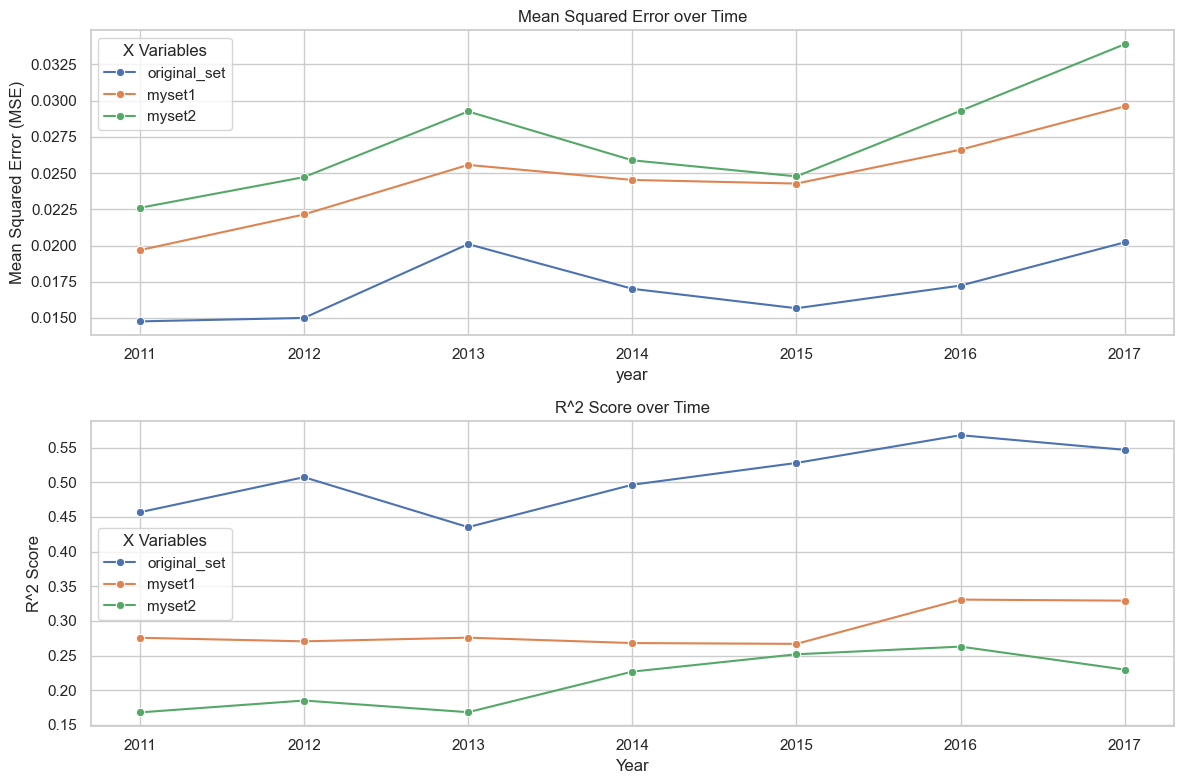

In [46]:
import matplotlib.pyplot as plt


# Initialize a larger figure with Seaborn style
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

# Plot MSE over time for each xvars method
plt.subplot(2, 1, 1)
sns.lineplot(data=results_df, x='year', y='mse', hue='xvars', marker='o')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Mean Squared Error over Time')
plt.legend(title='X Variables')

# Plot R^2 over time for each xvars method
plt.subplot(2, 1, 2)
sns.lineplot(data=results_df, x='year', y='r2', hue='xvars', marker='o')
plt.ylabel('R^2 Score')
plt.xlabel('Year')
plt.title('R^2 Score over Time')
plt.legend(title='X Variables')

plt.tight_layout()
plt.show()

*Insert answers to questions*
1. Which approach works best, on average?
The original set had the highest R-Squared with the lowest MSE across all years. 
2. Is there significant variation over time?
Significant is relative, over the course of the 7 years observed, our models generally only changed by .7 for our R-Squared. Our mean squared error changed dramatically though with all models increasing by .01 on average. 
3. Are there any large, noticeable differences? Do you have any theories as to where those come from?
The biggest change comes during the time period between 2012 to 2013. I have no theories to help answer why this happened. I want to assume it was something to do with the over all market. 

## Requirement 4

To wrap up, you're going to examine model performance in terms of MSE by size and by growth/value status. For the former, we'll use `AT` as a proxy for size. For the latter, we'll use the Book-to-Market ratio.

We'll examine these by decile (or buckets of 10). Let's first create our decile variables, and then compute the mean by each decile. Note that we're going to compute the deciles *by FYEAR*.

In [83]:
# Create deciles for Total Assets (AT) by fiscal year
both['size_decile'] = both.groupby('FYEAR')['AT'].transform(lambda x: pd.qcut(x, 10, labels=False))

# Calculate mean AT within each decile by year (for reference or analysis)
both['decile_AT'] = both.groupby(['size_decile'])['AT'].transform('mean')

# Calculate Book-to-Market ratio (BTM) for each observation
both['BTM'] = both['CEQ'] / (both['PRCC_F'] * both['CEQ'])

# Create deciles for BTM by fiscal year
both['btm_decile'] = both.groupby('FYEAR')['BTM'].transform(lambda x: pd.qcut(x, 10, labels=False))

# Calculate mean BTM within each decile by year (for reference or analysis)
both['decile_BTM'] = both.groupby(['btm_decile'])['BTM'].transform('mean')


Now, add the predictions you saved above to "both". If you did things correctly in the earlier requirement, the index should be aligned

In [84]:
allpredictions = pd.concat(predfs)
allpredictions.sort_index() # Does the index look similar?

,original_set,myset1,myset2
3,0.042848,0.050908,0.076962
4,0.025367,0.060160,0.078134
5,-0.005594,-0.052191,0.070143
6,0.011783,0.052241,0.071336
7,0.031937,0.058261,0.068340
...,...,...,...
34272,0.121028,-0.108767,-0.004631
34273,0.042086,-0.132771,0.025797
34277,0.034048,0.031963,0.053361
34278,0.032612,0.025729,0.058758


Now, merge the `allpredictions` data with `both` and call it `both2`:

In [85]:
both2 = pd.concat([both, allpredictions], axis=1)


Next, compute the squared-error based on predicted and actual, and then summarize by decile of size, and then decile of BTM:

In [86]:
# I did this for you:
for label in xvars.keys():
    both2[f'mse_{label}'] = (both2['fut_earn_at'] - both2[label])**2

Now, report the MSE by decile of size, and BTM:

In [87]:
mean_mse_by_size_decile = both2.groupby('decile_AT')[[f'mse_original_set', f'mse_myset1', f'mse_myset2']].mean()


mean_mse_by_size_decile, 


(              mse_original_set  mse_myset1  mse_myset2
 decile_AT                                             
 40.807871             0.042318    0.080006    0.067709
 128.251055            0.032352    0.050236    0.056273
 264.355036            0.025244    0.031140    0.042367
 465.972737            0.017527    0.019294    0.028178
 817.982925            0.013013    0.013487    0.018105
 1396.920767           0.013639    0.013544    0.018458
 2378.537509           0.009370    0.010483    0.012473
 4433.138982           0.005986    0.007912    0.008454
 10069.884441          0.007133    0.010313    0.010223
 62038.827635          0.004104    0.008642    0.008200,)

In [88]:
mean_mse_by_btm_decile = both2.groupby('decile_BTM')[[f'mse_original_set', f'mse_myset1', f'mse_myset2']].mean()

mean_mse_by_btm_decile

,mse_original_set,mse_myset1,mse_myset2
decile_BTM,,,
0.009506,0.007328,0.009981,0.017148
0.016069,0.007451,0.010905,0.015569
0.021982,0.007289,0.010357,0.014217
0.029533,0.008747,0.013186,0.017240
0.040426,0.012932,0.017908,0.021344
0.056104,0.013152,0.017894,0.021876
0.081544,0.018387,0.024553,0.028302
0.129314,0.026891,0.036214,0.038771
0.232884,0.033940,0.046111,0.045650


Comment on any trends you observe. Do you have any explanation for these patterns?

*INSERT ANSWER*
For both sets of data, the distrubution seems to be mainly skewed to smaller companies/lower Book-to-Market ratios. The lowest MSE was found in the original set with my set 1 performing second best. My main explanation for the companies skeweness towards lower values in both cases is that the top companies are not common. You will find many companies in the smaller deciles because there are just more of them entirely. 

## Requirement 5 (6046 only)
Now evaluate the forecast errors by industry. Which industry, defined by two-digit SIC code, has the lowest MSE for your best model? Which industry has the highest? Comment on whether you find this intuitive.

Note that once you identify the industries, you can look up industry definitions online, or using the datafile included with task materials (`sic_2_digit_codes.xls`).

(HINT: There will be more SIC codes than the 10 deciles we inspect above. You can identify the maximum or minimum values for each MSE measure using either `sort_values()`, sorting by whatever MSE you'd like to view, or, more directly, `idmax()` and `idxmin()`.)

In [89]:
both2['sic2'] = both2['SIC'].astype(str).str[:2]

In [94]:
average_mse_by_sic2 = both2.groupby('sic2')[[f'mse_{label}' for label in xvars.keys()]].mean()
# Sort the average MSE by 'sic2' from highest to lowest
average_mse_by_sic2 = average_mse_by_sic2.sort_values(by=[col for col in average_mse_by_sic2.columns], ascending=False)

# Display the sorted result
print(average_mse_by_sic2)

      mse_original_set  mse_myset1  mse_myset2
sic2                                          
28            0.051228    0.083871    0.090833
13            0.037330    0.039522    0.037741
57            0.033822    0.021521    0.021523
27            0.020265    0.015063    0.026115
14            0.019808    0.016556    0.015797
46            0.019369    0.044068    0.043072
38            0.018943    0.037799    0.035563
73            0.016686    0.021435    0.027288
47            0.016650    0.017185    0.032724
39            0.015797    0.014620    0.020878
80            0.015539    0.022095    0.026034
87            0.015175    0.023020    0.020232
10            0.014591    0.020293    0.018769
44            0.014120    0.015804    0.015092
23            0.014037    0.011777    0.018834
79            0.013917    0.014430    0.017935
56            0.013811    0.012332    0.018047
36            0.013500    0.019120    0.018947
21            0.011018    0.013701    0.013485
59           

*INSERT ANSWER*
28 represents chemicals and allied products, our models works bad when computing earnings for this industry most likely because chemicals is a very mature industry where predicting future cash flow is quite difficult. There are no big break-throughs or huge earning announcements that will catch people off guard. It is commodities so all companies are usually in price wars where little happens between financial years. Because of this chemical companies will often take hits when their commodities go up in price. If we built a model that included commodity pricing, we would assume that we would do very well in predicting earnings but sadly we did not. 

40 represents railroad transportation, our models did really well when predicting future earnings for these companies for several reasons. First is that stable demand of the industry often means that cash flows are cyclical and move up and down with the rest of the industry. Long term contracts mean that it is highly unlikely that there are unpredictable changes in earnings. Also unlike chemicals, the railroad industry does not care about commodity pricing.

...
